## Importing and Initializing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os

In [2]:
data_dir = "data"   # Folder where images are stored
img_file = "data\subject01.sad"
processed_dir = "processed_data"

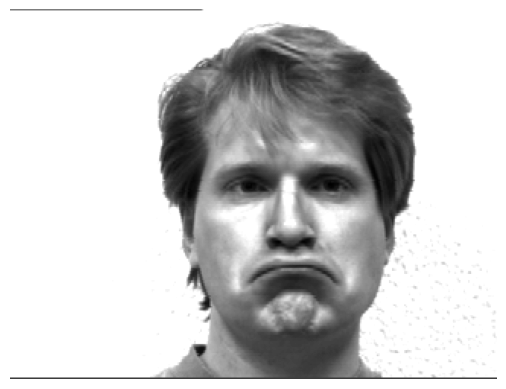

In [3]:
img = Image.open(img_file)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [4]:
type(img)

PIL.GifImagePlugin.GifImageFile

In [5]:
img_ndarray = np.asarray(img)
img_ndarray.shape

(243, 320)

In [6]:
(img_ndarray.min(),img_ndarray.max())

(9, 255)

In [7]:
def get_array(subject_id, expression, directory):
    target_filename = f"subject{subject_id}.{expression}"
    
    for filename in os.listdir(directory):
        if filename == target_filename: 
            filepath = os.path.join(directory, filename)
            try:
                img = Image.open(filepath)
                img_ndarray = np.asarray(img)
                return img_ndarray
                
            except IOError:
                print(f"Cannot open file: {filepath}")
    
    print(f"File {target_filename} not found in directory.")
    return None  # Return None if no matching file is found
    
    

# Image Visualization and Preprocessing

1. Look at the data
2. Check if all of them are of same size. If not, resize.
3. Normalize the image to [0,1]

## Data Visualization

In [8]:
def show_data(subject_id):
    emotions = ['centerlight', 'happy', 'leftlight', 'glasses', 'normal', 
                'rightlight', 'sad', 'sleepy', 'surprised', 'wink','noglasses']

    # Initialize list to store images.
    images = []
     # Load images for the specified subject
    for emotion in emotions:
        filename = f'subject{subject_id}.{emotion}'
        filepath = os.path.join(data_dir, filename)
        try:
            img = Image.open(filepath)  #Data type of img: PIL.GifImagePlugin.GifImageFile
            images.append(img)
        except FileNotFoundError:
            print(f"File not found: {filepath}")

    # Define the grid size for visualization
    grid_size = (3,4) 

    # Create a new figure
    plt.figure(figsize=(15,12))

    # Plot each image
    for i, img in enumerate(images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(img, cmap='gray')  # Show image in grayscale
        plt.axis('off')
        plt.title(f'{emotions[i]}', fontsize=10) 

    # Adjust layout and show plot
    plt.tight_layout()
    plt.suptitle(f"Images of Subject {subject_id}", fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()


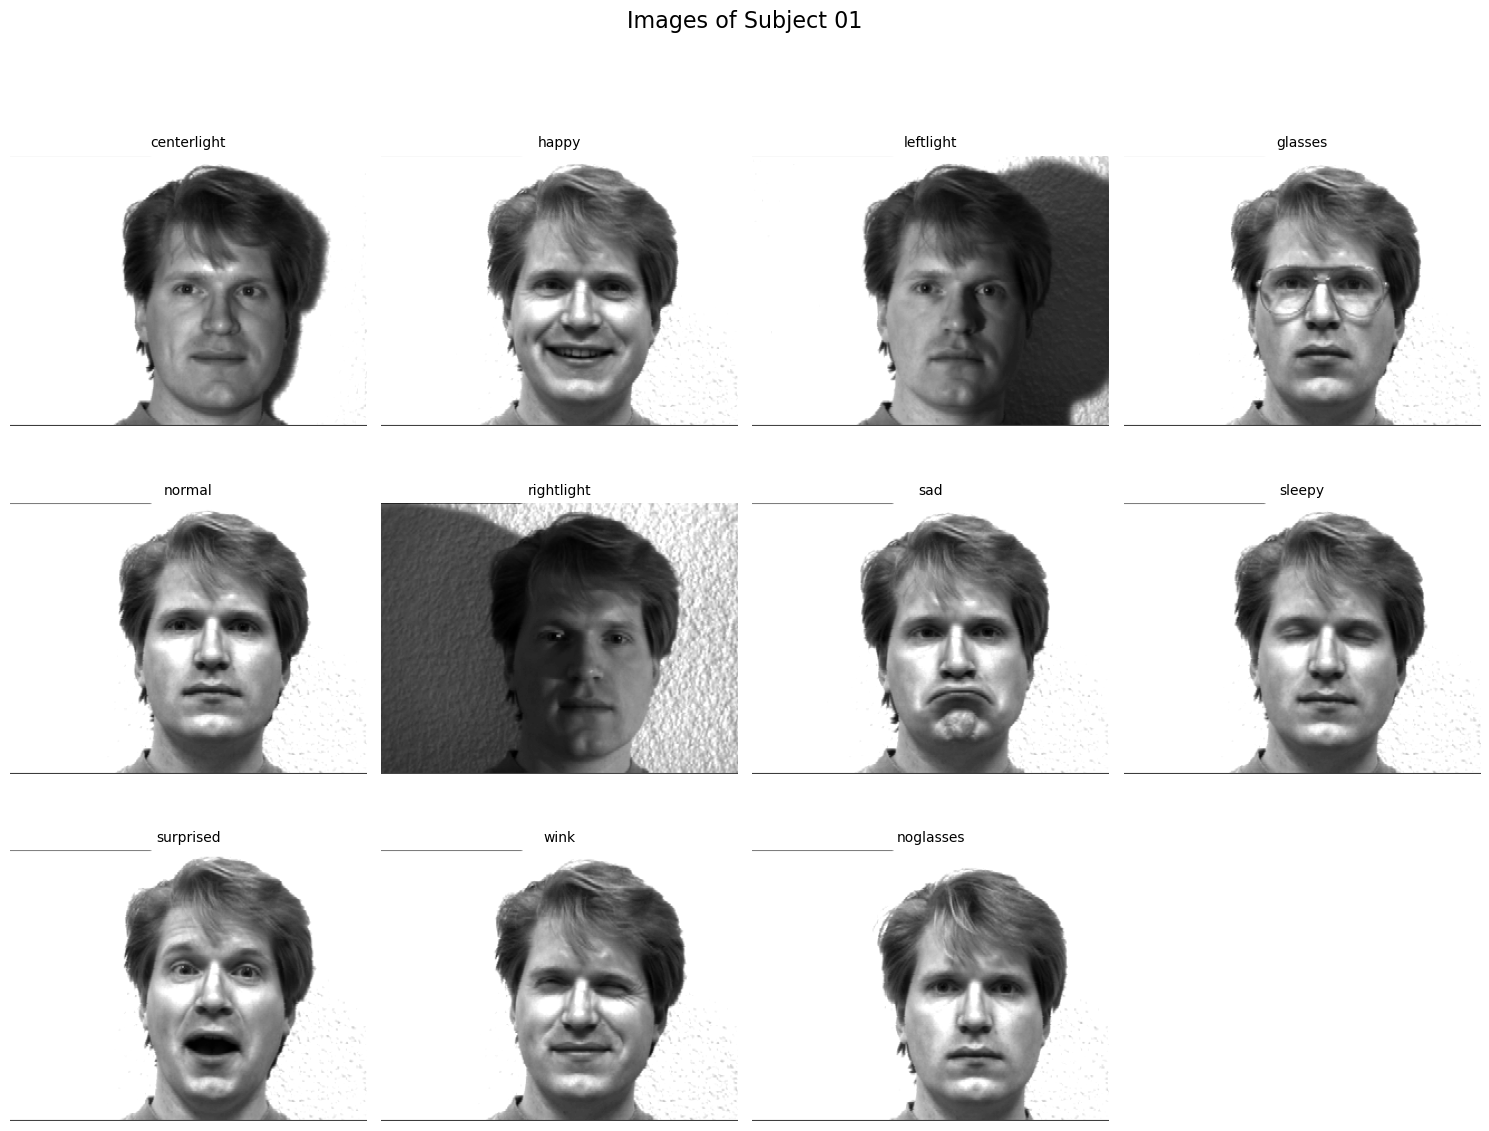

In [9]:
show_data(subject_id='01')

## Check if all the images are of same size

In [10]:
def isSameSize(directory):
  
    sizes = set()  # Use a set to store unique sizes

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                sizes.add(img.size)  # Add size (width, height) to the set
        except IOError:
            print(f"Cannot open file: {filepath}")

    if len(sizes) == 1:  #since sizes is a set, it will not store duplicates.
        # All images have the same size
        size = sizes.pop()  # Get the unique size
        print(f"All the images are of size. \nThe size is {size}")
    else:
        # Images have different sizes
        return False, None



In [11]:
isSameSize(data_dir)

All the images are of size. 
The size is (320, 243)


## Normalization

Normalization helps improve the performance and convergence speed of machine learning algorithms.
Normalizing the pixel values to [0,1]

In [11]:
def normalize_image(directory, output_directory):

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                img_ndarray = np.asarray(img, dtype=np.float32)
                img_ndarray = img_ndarray.copy() 
                img_ndarray /= 255.0

            output_filepath = os.path.join(output_directory, f"{filename}.npy")
            np.save(output_filepath, img_ndarray)
                
        except IOError:
            print(f"Cannot open file: {filepath}")

    
    return True

This function normalizes the image and stores in the folder named processed_data

In [ ]:
normalize_image(data_dir,processed_data)

## Opening Normalized Image

In [13]:
def processed_img(subject_id, expression, directory):
    target_filename = f"subject{subject_id}.{expression}.npy"
    
    for filename in os.listdir(directory):
        if filename == target_filename: 
            filepath = os.path.join(directory, filename)
            try:
                # Load the numpy array
                img_ndarray = np.load(filepath)
                return img_ndarray  # Return the loaded array once found
                
            except IOError:
                print(f"Cannot open file: {filepath}")
    
    print(f"File {target_filename} not found in directory.")
    return None  # Return None if no matching file is found

    

In [106]:
img_ndarray = processed_img("02", "happy", processed_dir)

In [ ]:
(img_ndarray.min(),img_ndarray.max())

# Feature Extraction

1. Local Binary Pattern
2. Gabor filter
3. Laplacian of Gaussian (LoG)
4. Gray-Level Co-occurrence Matrix (GLCM)

## Local Binary Pattern

 Local Binary Patterns (LBPs) method relies on feature extraction for face recognition.
 
 [2004_Ahonen]
 The face area is first divided into small regions from which Local Binary Pattern (LBP) histograms are extracted and concatenated into a single, spatially enhanced feature histogram efficiently representing the face image. Considers both shape and texture information to represent the face images. The textures of the facial regions are locally encoded by the LBP patterns while the whole shape of the face is recovered by the construction of the face feature histogram. The idea behind using the LBP features is that the face images can be seen as composition of micro-patterns which are invariant with respect to monotonic grey scale transformations. Combining these micro-patterns, a global description of the face image is obtained. By dividing the image into cells we can introduce locality into our final feature vector.

 1.  For neighbourhoods we will use the notation (P,R) which means P sampling points on a circle of radius of R.
 2. A Local Binary Pattern is called uniform if it contains at most two bitwise transitions from 0 to 1 or vice versa when the binary string is considered circular. For example, 00000000, 00011110 and 10000011 are uniform patterns.


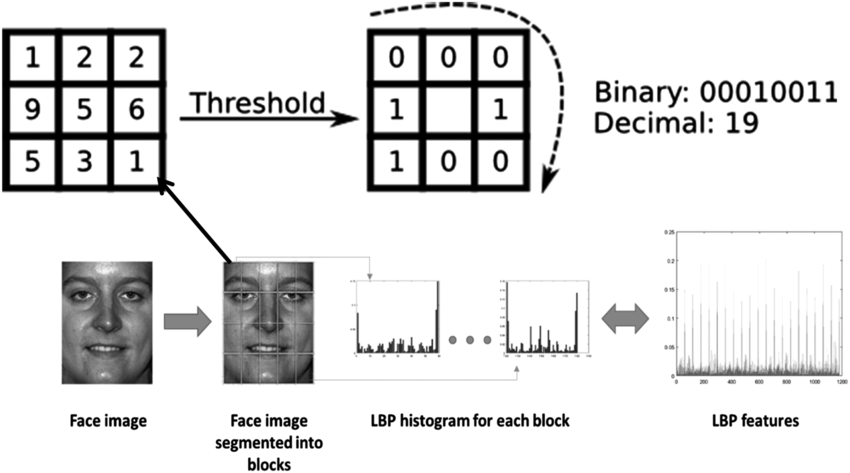    

In [12]:
from skimage.feature import local_binary_pattern

In [ ]:
local_binary_pattern?

In [24]:
def lbp_features(image, radius=1, n_points=8):
    # Compute LBP for the image
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    #The "uniform" method in the local_binary_pattern function refers to a special LBP variant that reduces the dimensionality of the LBP feature vector while preserving the most important texture information.
    
    # Extract histogram of LBP patterns to make feature vectors comparable, independent of image size.
    n_bins = int(lbp.max() + 1)  
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    #Flattens the LBP array to a 1D array. ravel() is used to ensure that the np.histogram function receives a 1D array of LBP values.
    
    # Normalize the histogram for texture analysis.
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Avoid division by zero

    #Normalization is important because it ensures that the LBP feature vector (the histogram) is comparable across different images, regardless of their size or the number of pixels. Without normalization, the histogram would represent raw counts, and larger images would naturally have larger counts, making comparisons unfair.
    
    return lbp, lbp_hist


In [25]:
i = get_array("01", "happy", data_dir)
lbp, lbp_hist = lbp_features(i)
n_bins = len(lbp_hist)

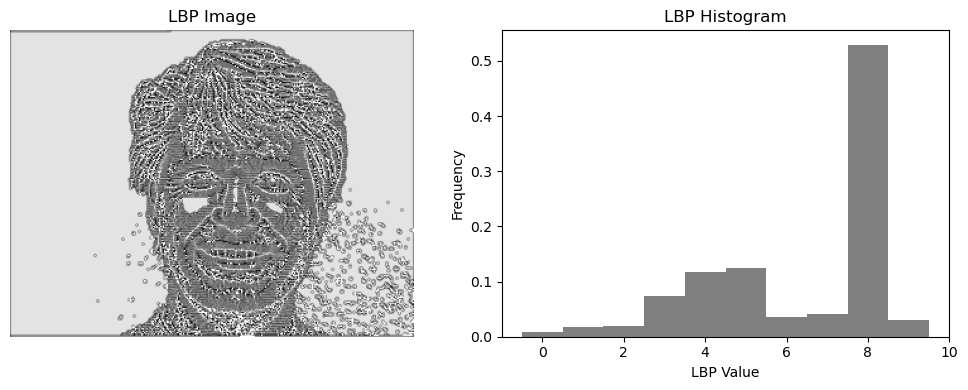

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Display the LBP image
axs[0].imshow(lbp, cmap='gray')
axs[0].set_title('LBP Image')
axs[0].axis('off')

# Display the histogram of LBP features
axs[1].bar(range(n_bins), lbp_hist, width=1.0, color='gray')
axs[1].set_title('LBP Histogram')
axs[1].set_xlabel('LBP Value')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

## Gabor Filter

In [28]:
from skimage.filters import gabor

In [ ]:
def extract_gabor(image, frequencies=[0.1, 0.2], orientations=[0, np.pi/4, np.pi/2]):
    features = []
    
    for freq in frequencies:
        for theta in orientations:
            # Apply Gabor filter
            filtered_real, filtered_imag = gabor(image, frequency=freq, theta=theta)
            
            # Extract mean and variance of the filter responses as features
            mean_real = np.mean(filtered_real)
            var_real = np.var(filtered_real)
            
            features.append(mean_real)
            features.append(var_real)
    
    return np.array(features)


Gabor filters capture frequency and orientation information.
Explanation:

    frequencies: List of frequencies for Gabor filters.
    orientations: List of orientations (angles) for the filters.
    The features extracted are the mean and variance of the filtered image responses.

## Laplacian of Gaussian (LOG)

LoG is used for edge detection and blob detection in images
Explanation:

    sigma: Controls the scale of Gaussian smoothing before applying the Laplace filter.
    The features extracted are the mean and variance of the LoG responses.

In [ ]:
from skimage.filters import laplace, gaussian
import numpy as np

def extract_log(image, sigma=1.0):
    # Apply Gaussian filter to smooth the image
    smoothed_image = gaussian(image, sigma=sigma)
    
    # Apply Laplace filter
    log_image = laplace(smoothed_image)
    
    # Extract the mean and variance of LoG responses as features
    mean_log = np.mean(log_image)
    var_log = np.var(log_image)
    
    return np.array([mean_log, var_log])


## Gray-Level Co-occurrence Matrix (GLCM)

GLCM is used for texture analysis based on pixel spatial relationships.
Explanation:

    distances: List of pixel distances for GLCM computation.
    angles: List of angles for GLCM (e.g., 0, 45, 90, 135 degrees).
    properties: The texture properties you want to extract (e.g., contrast, correlation, energy, and homogeneity).

In [ ]:
from skimage.feature import greycomatrix, greycoprops
import numpy as np

def extract_glcm(image, distances=[1], angles=[0], properties=['contrast', 'correlation', 'energy', 'homogeneity']):
    # Compute GLCM
    glcm = greycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)
    
    # Extract GLCM properties
    features = []
    for prop in properties:
        feature = greycoprops(glcm, prop)
        features.append(feature.mean())
    
    return np.array(features)


# Combining the features

After extracting all the features from each image, you can concatenate them to form a single feature vector for the image.

In [ ]:
def extract_all_features(image):
    # Extract different features
    lbp_features = extract_lbp(image)
    gabor_features = extract_gabor(image)
    log_features = extract_log(image)
    glcm_features = extract_glcm(image)
    
    # Combine all features into a single feature vector
    feature_vector = np.hstack([lbp_features, gabor_features, log_features, glcm_features])
    
    return feature_vector


## Next Steps:

    Loop through all preprocessed images, apply the feature extraction methods, and save the features for each image.
    Store the extracted features in a format (e.g., NumPy arrays, .csv, or .txt files) suitable for machine learning models.

# Applying ML models

# Metrics of the model